<a href="https://colab.research.google.com/github/Ashish-Abraham/LLM-Boilerplate/blob/main/GPTFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

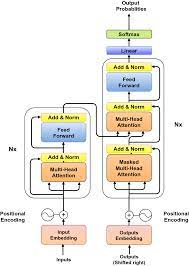

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, attention_dim, bias=False, dropout=0.1):
        super().__init__()
        self.w_key = nn.Linear(embed_dim, attention_dim, bias=bias)
        self.w_query = nn.Linear(embed_dim, attention_dim, bias=bias)
        self.w_value = nn.Linear(embed_dim, attention_dim, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, _ = x.size()
        """
        [
            [write vector],
            [me vector],
            [a vector],
            [poem vector],
        ]
        """

        k = self.w_key(x)   # (B, T, A)
        q = self.w_query(x) # (B, T, A)
        v = self.w_value(x) # (B, T, A)

        # Scaled dot-product attention
        scores = (q @ k.transpose(-2, -1)) / (k.size(-1) ** 0.5)  # (B, T, T)

        # Causal mask (future positions masked)
        mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        scores = scores.masked_fill(mask, float('-1e10'))

        attn = scores.softmax(dim=-1)  # (B, T, T)

        attn = self.dropout(attn)

        return attn @ v  # (B, T, A)


In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, attention_dim, dropout=0.1):
        super().__init__()
        self.head_size = attention_dim//num_heads
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(SelfAttention(embed_dim=embed_dim, attention_dim=self.head_size,dropout=dropout))

    def forward(self,x):
        head_outputs = []
        for head in self.heads:
            head_outputs.append(head(x)) #B x T x A//num_heads
        concatenated = torch.cat(head_outputs, dim = 2)
        return concatenated


In [4]:
class FeedForward(nn.Module):
    def __init__(self,attention_dim):
        super().__init__()
        self.up = nn.Linear(attention_dim,attention_dim*4)
        self.relu = nn.GELU()
        self.down = nn.Linear(attention_dim*4,attention_dim)
    def forward(self,x):
        return self.down(self.relu(self.up(x)))


In [5]:
class Decoder(nn.Module):
    def __init__(self,num_heads,embed_dim,attention_dim, dropout=0.1):
        super().__init__()
        self.masked_multihead = MultiHeadAttention(num_heads, embed_dim, attention_dim, dropout)
        self.feed_forward = FeedForward(attention_dim)
        self.n1 = nn.LayerNorm(attention_dim)
        self.n2 = nn.LayerNorm(attention_dim)
    def forward(self,x):
        e = self.masked_multihead(self.n1(x))
        e =  e + x
        e = self.feed_forward(self.n2(e))
        return e



In [6]:
class GPT(nn.Module):
    def __init__(self, num_heads, vocab_size, embed_dim, attention_dim, num_blocks, context_length, dropout_rate):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, attention_dim)
        self.positional_embedding = nn.Embedding(context_length, attention_dim)

        self.decoders = nn.ModuleList([
            Decoder(num_heads, attention_dim, attention_dim, dropout_rate) for _ in range(num_blocks)
        ])

        self.exit_norm = nn.LayerNorm(attention_dim)
        self.linear = nn.Linear(attention_dim, vocab_size)

    def forward(self, context):
        embeddings = self.embedding(context)
        context_len = context.shape[1]
        position = torch.arange(context_len, device=context.device).unsqueeze(0)
        position_embeddings = self.positional_embedding(position)

        e = embeddings + position_embeddings

        for decoder in self.decoders:
            e = decoder(e)

        return self.linear(self.exit_norm(e))


In [7]:
int_to_char = {0: '\n', 1: ' ', 2: '!', 3: '"', 4: '$', 5: '%', 6: '&', 7: "'", 8: '(', 9: ')', 10: '*', 11: '+', 12: ',', 13: '-', 14: '.', 15: '/', 16: '0', 17: '1', 18: '2', 19: '3', 20: '4', 21: '5', 22: '6', 23: '7', 24: '8', 25: '9', 26: ':', 27: ';', 28: '?', 29: 'A', 30: 'B', 31: 'C', 32: 'D', 33: 'E', 34: 'F', 35: 'G', 36: 'H', 37: 'I', 38: 'J', 39: 'K', 40: 'L', 41: 'M', 42: 'N', 43: 'O', 44: 'P', 45: 'Q', 46: 'R', 47: 'S', 48: 'T', 49: 'U', 50: 'V', 51: 'W', 52: 'X', 53: 'Y', 54: 'Z', 55: '[', 56: ']', 57: '_', 58: 'a', 59: 'b', 60: 'c', 61: 'd', 62: 'e', 63: 'f', 64: 'g', 65: 'h', 66: 'i', 67: 'j', 68: 'k', 69: 'l', 70: 'm', 71: 'n', 72: 'o', 73: 'p', 74: 'q', 75: 'r', 76: 's', 77: 't', 78: 'u', 79: 'v', 80: 'w', 81: 'x', 82: 'y', 83: 'z', 84: '{', 85: '|', 86: '}', 87: 'à', 88: 'á', 89: 'è', 90: 'é', 91: 'ë', 92: 'ñ', 93: 'ó', 94: 'ú', 95: '\u2005', 96: '–', 97: '—', 98: '‘', 99: '’', 100: '“', 101: '”', 102: '…', 103: '\u205f'}

def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = float('-inf')
    return out


def generate_text(model, new_chars, context, context_length, int_to_char, temperature=1.0, top_k=None):
    res = []
    for _ in range(new_chars):
        if context.shape[1] > context_length:
            context = context[:, -context_length:]

        logits = model(context)  # [B, T, V]
        logits = logits[:, -1, :]  # [B, V]
        logits = logits / max(temperature, 1e-3)

        if top_k is not None:
            logits = top_k_logits(logits, top_k)

        if torch.isnan(logits).any() or torch.isinf(logits).any():
            raise ValueError("Logits contain NaN or Inf")

        probabilities = nn.functional.softmax(logits, dim=-1)
        probabilities = torch.clamp(probabilities, min=1e-9, max=1.0)

        next_token = torch.multinomial(probabilities, 1)  # [B, 1]
        context = torch.cat((context, next_token), dim=1)
        res.append(int_to_char[next_token.item()])

    return ''.join(res)

def generate(model, max_new_tokens, context, context_length, temperature=1.0, top_k=None):
    res = []
    for _ in range(max_new_tokens):
        if context.shape[1] > context_length:
            context = context[:, -context_length:]

        logits = model(context)  # [B, T, V]
        logits = logits[:, -1, :]  # [B, V]
        logits = logits / max(temperature, 1e-3)

        if top_k is not None:
            logits = top_k_logits(logits, top_k)

        if torch.isnan(logits).any() or torch.isinf(logits).any():
            raise ValueError("Logits contain NaN or Inf")

        probabilities = nn.functional.softmax(logits, dim=-1)
        probabilities = torch.clamp(probabilities, min=1e-9, max=1.0)

        next_token = torch.multinomial(probabilities, 1)  # [B, 1]
        context = torch.cat((context, next_token), dim=1)


    return context



### GPT2-124M

| Parameter      | Value   | Description                 |
|----------------|---------|-----------------------------|
| `vocab_size`   | 50257   | Vocabulary size             |
| `context_length`| 1024    | Context length              |
| `emb_dim`      | 768     | Embedding dimension         |
| `n_heads`      | 12      | Number of attention heads   |
| `n_layers`     | 12      | Number of layers            |
| `drop_rate`    | 0.1     | Dropout rate                |
| `qkv_bias`     | False   | Query-Key-Value bias        |

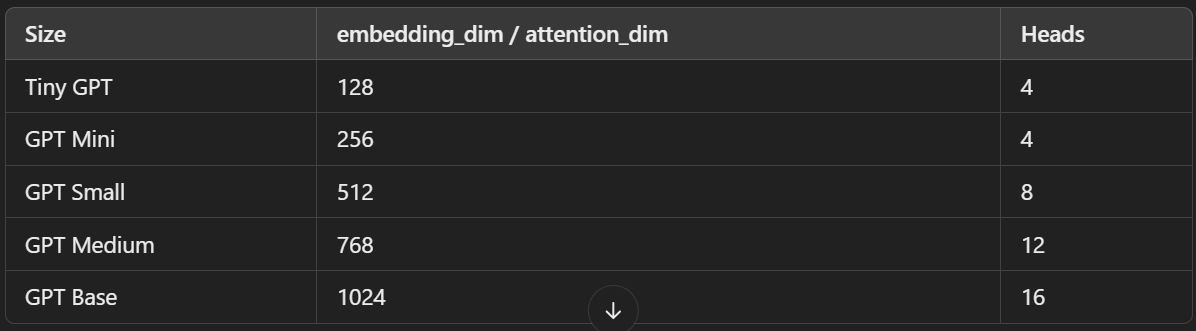

In [8]:
vocab_size = 104             # Number of tokens in your vocabulary
context_length = 128         # Maximum sequence length (tokens)
embed_dim = 256              # Token embedding size
attention_dim = 256          # Attention projection dimension (keep same as embed_dim)
num_heads = 4                # Number of attention heads (must divide attention_dim)
num_blocks = 6               # Number of decoder blocks (layers)
num_words = 5000
dropout_rate=0.1           # Number of new tokens to generate (optional tuning)

# Initial context (starting token or BOS)
context = torch.zeros(1, 1, dtype=torch.int64).to(device)

model = GPT(num_heads,vocab_size,embed_dim,attention_dim,num_blocks,context_length,dropout_rate).to(device)
model.eval()

GPT(
  (embedding): Embedding(104, 256)
  (positional_embedding): Embedding(128, 256)
  (decoders): ModuleList(
    (0-5): 6 x Decoder(
      (masked_multihead): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x SelfAttention(
            (w_key): Linear(in_features=256, out_features=64, bias=False)
            (w_query): Linear(in_features=256, out_features=64, bias=False)
            (w_value): Linear(in_features=256, out_features=64, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (feed_forward): FeedForward(
        (up): Linear(in_features=256, out_features=1024, bias=True)
        (relu): GELU(approximate='none')
        (down): Linear(in_features=1024, out_features=256, bias=True)
      )
      (n1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (n2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (exit_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (linear):

In [9]:
# generate_text(model,num_words,context,context_length,int_to_char)

# Train

In [10]:
!pip install datasets

In [11]:
!curl -X GET "https://datasets-server.huggingface.co/rows?dataset=huggingartists%2Fcoldplay&config=default&split=train&offset=0&length=100" -o coldplay_data.json
import json
import pandas as pd

with open('coldplay_data.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data['rows'])
display(df.head())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  100k  100  100k    0     0   112k      0 --:--:-- --:--:-- --:--:--  112k


,row_idx,row,truncated_cells
0,0,{'text': 'Ive been reading books of old The le...,[]
1,1,"{'text': 'Come up to meet you, tell you Im sor...",[]
2,2,{'text': 'I used to rule the world Seas would ...,[]
3,3,"{'text': 'When you try your best, but you dont...",[]
4,4,{'text': 'Look at the stars Look how they shin...,[]


In [12]:
df = df.drop(columns=['truncated_cells'])
df['text'] = df['row'].apply(lambda x: x['text'])
df = df.drop(columns=['row'])
display(df.head())

,row_idx,text
0,0,Ive been reading books of old\nThe legends and...
1,1,"Come up to meet you, tell you Im sorry\nYou do..."
2,2,I used to rule the world\nSeas would rise when...
3,3,"When you try your best, but you dont succeed\n..."
4,4,Look at the stars\nLook how they shine for you...


In [13]:
import re
# Select subsets
train_subset = df.iloc[:90]
test_subset = df.iloc[90:]

# Extract and clean lyrics
def keep_english_only(text):
    return re.sub(r"[^\x00-\x7F]+", "", text)

# Process training lyrics
train_lyrics = [keep_english_only(row["text"]) for index, row in train_subset.iterrows()]
joined_train_lyrics = '\n'.join(train_lyrics)

# Process test lyrics
test_lyrics = [keep_english_only(row["text"]) for index, row in test_subset.iterrows()]
joined_test_lyrics = '\n'.join(test_lyrics)

full_lyrics = joined_train_lyrics + '\n' + joined_test_lyrics

In [14]:
full_lyrics[:200]

'Ive been reading books of old\nThe legends and the myths\nAchilles and his gold\nHercules and his gifts\nSpider-Mans control\nAnd Batman with his fists\nAnd clearly I dont see myself upon that list\nBut she '

In [15]:
characters = list(set(full_lyrics))
len(characters)

65

## Word Tokenizer

In [16]:
import tiktoken

# Alternatively:
# from llms_from_scratch.ch04 import generate_text_simple

def text_to_token_ids(text, tokenizer, device):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0).to(device) # add batch dimension and move to device
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


start_context = "I want something"
tokenizer = tiktoken.get_encoding("gpt2")

In [74]:
vocab_size = tokenizer.n_vocab           # GPT-2 tokenizer vocab size
context_length = 256                     # Reduced context length for faster training
embed_dim = 256                          # Smaller embedding dimension
attention_dim = 256                      # Keep same as embed_dim
num_heads = 4                           # Divisible by attention_dim
num_blocks = 4                          # Fewer blocks for smaller model
dropout_rate = 0.25

# Initial context (starting token or BOS)
context = torch.zeros(1, 1, dtype=torch.int64).to(device)

model = GPT(num_heads,vocab_size,embed_dim,attention_dim,num_blocks,context_length, dropout_rate).to(device)
model.eval()

GPT(
  (embedding): Embedding(50257, 256)
  (positional_embedding): Embedding(256, 256)
  (decoders): ModuleList(
    (0-3): 4 x Decoder(
      (masked_multihead): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x SelfAttention(
            (w_key): Linear(in_features=256, out_features=64, bias=False)
            (w_query): Linear(in_features=256, out_features=64, bias=False)
            (w_value): Linear(in_features=256, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
      )
      (feed_forward): FeedForward(
        (up): Linear(in_features=256, out_features=1024, bias=True)
        (relu): GELU(approximate='none')
        (down): Linear(in_features=1024, out_features=256, bias=True)
      )
      (n1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (n2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (exit_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (linear

In [75]:
token_ids = generate(
    model=model,
    context=text_to_token_ids(start_context, tokenizer, device),
    max_new_tokens=10,
    context_length=context_length
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 I want something introduceウ coaches Kard Judaism trendsCommerce rotating infiltration approach


### Pretraining

In [66]:
from datasets import load_dataset
import re

# Load dataset
ds = load_dataset("stanfordnlp/imdb")

# Function to keep only English (ASCII) characters
def keep_english_only(text):
    return re.sub(r"[^\x00-\x7F]+", "", text)

# Function to clean and combine a list of texts
def combine_and_clean(text_list):
    # Keep only English
    cleaned_list = [keep_english_only(t) for t in text_list]
    # Combine into one string
    combined = " ".join(cleaned_list)
    # Remove extra spaces/newlines
    combined = re.sub(r'\s+', ' ', combined).strip()
    return combined

# Create separate combined strings
train_text_data = combine_and_clean(ds['train']['text'])
test_text_data = combine_and_clean(ds['test']['text'])

print(f"Train text length: {len(train_text_data)} characters")
print(f"Test text length: {len(test_text_data)} characters")

# Preview first 300 chars from each
print("\nTrain preview:", train_text_data[:300])
print("\nTest preview:", test_text_data[:300])



KeyboardInterrupt: 

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader



class CustomDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})


        # Use a sliding window to chunk the data into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_encoded_dataloader(txt, tokenizer, batch_size=4, max_length=128,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):

    # Create dataset
    dataset = CustomDataset(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

In [45]:
total_characters = len(train_text_data)
total_tokens = len(tokenizer.encode(train_text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

# Sanity check

if total_tokens * (0.95) < context_length:
    print("Not enough tokens for the training loader. "
          "Try to lower the context_length or "
          "increase the `training_ratio`")

if total_tokens * (1-0.95) <context_length:
    print("Not enough tokens for the validation loader. "
          "Try to lower the context_length or "
          "decrease the `training_ratio`")

Characters: 33151242
Tokens: 7488757


In [41]:


# Create training and validation dataloaders
train_dataloader = create_encoded_dataloader(
    train_text_data,
    tokenizer=tokenizer,
    batch_size=2,
    max_length=context_length,
    stride=context_length,
    shuffle=True,
    drop_last=True
)

test_dataloader = create_encoded_dataloader(
    test_text_data,
    tokenizer=tokenizer,
    batch_size=2,
    max_length=context_length,
    stride=context_length,
    shuffle=False,
    drop_last=True
)



In [42]:
print(f"Number of batches in training dataloader: {len(train_dataloader)}")
print(f"Number of batches in validation dataloader: {len(test_dataloader)}")
print("Train loader:")
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

print("\ntest loader:")
for x, y in test_dataloader:
    print(x.shape, y.shape)
    break

Number of batches in training dataloader: 384
Number of batches in validation dataloader: 54
Train loader:
torch.Size([2, 64]) torch.Size([2, 64])

test loader:
torch.Size([2, 64]) torch.Size([2, 64])


In [29]:
train_tokens = 0
for input_batch, target_batch in train_dataloader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in test_dataloader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 29184
Validation tokens: 2816
All tokens: 32000


In [76]:
settings = {
    "learning_rate": 8e-5,              # Lower starting LR
    "weight_decay": 0.008,
    "num_epochs": 150,                  # More epochs with lower LR
    "batch_size": 8,                   # Slightly smaller batch size
    "warmup_steps": 800,                # Shorter warmup
    "max_lr": 1.5e-4,                     # Much lower peak learning rate
    "min_lr": 5e-7,                     # Lower minimum learning rate
    "eval_freq": 25,                    # Less frequent evaluation
    "eval_iter": 8,                     # Fewer batches for evaluation
    "gradient_clip": 0.8,               # Lower gradient clipping
    "patience": 25,                     # More patience
    "min_improvement": 2e-4             # Minimum improvement threshold
}

def initialize_weights(module):
    if isinstance(module, nn.Linear):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    elif isinstance(module, nn.LayerNorm):
        torch.nn.init.ones_(module.weight)
        torch.nn.init.zeros_(module.bias)

# Apply initialization
model.apply(initialize_weights)

GPT(
  (embedding): Embedding(50257, 256)
  (positional_embedding): Embedding(256, 256)
  (decoders): ModuleList(
    (0-3): 4 x Decoder(
      (masked_multihead): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x SelfAttention(
            (w_key): Linear(in_features=256, out_features=64, bias=False)
            (w_query): Linear(in_features=256, out_features=64, bias=False)
            (w_value): Linear(in_features=256, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
      )
      (feed_forward): FeedForward(
        (up): Linear(in_features=256, out_features=1024, bias=True)
        (relu): GELU(approximate='none')
        (down): Linear(in_features=1024, out_features=256, bias=True)
      )
      (n1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (n2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (exit_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (linear

In [78]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
import matplotlib.pyplot as plt
import math
from torch.optim.lr_scheduler import LambdaLR

def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5, last_epoch=-1):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases from 0 to the initial lr.
    """
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return LambdaLR(optimizer, lr_lambda, last_epoch)

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    # Reshape logits and targets for CrossEntropyLoss
    loss = torch.nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), target_batch.view(-1))
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    with torch.no_grad(): # Disable gradient calculations during evaluation
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i < num_batches:
                loss = calc_loss_batch(input_batch, target_batch, model, device)
                total_loss += loss.item()
            else:
                break
    return total_loss / num_batches


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context, context_length, num_chars=100):
    model.eval()
    # Convert start_context to token IDs using the provided function
    context_tensor = text_to_token_ids(start_context, tokenizer, device)

    with torch.no_grad():
        # Generate text using the generate function
        generated_tokens = generate(model, num_chars, context_tensor, context_length=context_length)
        # Decode tokens to text using the provided function
        decoded_text = token_ids_to_text(generated_tokens, tokenizer)

        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


def train_model(model, train_loader, val_loader, device, settings, tokenizer, context_length):

    # Initialize optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=settings["learning_rate"],
        weight_decay=settings["weight_decay"],
        betas=(0.9, 0.95),
        eps=1e-8
    )

    # Calculate total training steps
    total_steps = len(train_loader) * settings["num_epochs"]

    # Initialize scheduler with warmup
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=settings["warmup_steps"],
        num_training_steps=total_steps
    )

    # Training tracking
    train_losses, val_losses = [], []
    epochs_seen, tokens_seen = [], []
    learning_rates = []
    total_tokens = 0
    global_step = 0

    # Improved early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    val_loss_history = []

    print(f"Starting training for {settings['num_epochs']} epochs")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Total training steps: {total_steps}")
    print(f"Warmup steps: {settings['warmup_steps']}")

    model.train()

    for epoch in range(settings["num_epochs"]):
        epoch_loss = 0.0
        num_batches = 0

        for i, (input_batch, target_batch) in enumerate(train_loader):
            global_step += 1
            total_tokens += input_batch.numel()

            # Forward pass
            loss = calc_loss_batch(input_batch, target_batch, model, device)

            # Check for NaN/Inf
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss detected at step {global_step}")
                continue

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), settings["gradient_clip"])

            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()
            num_batches += 1

            # Log current learning rate
            current_lr = scheduler.get_last_lr()[0]
            learning_rates.append(current_lr)

            # Evaluation and logging
            if global_step % settings["eval_freq"] == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, settings["eval_iter"]
                )

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                epochs_seen.append(epoch + (i + 1) / len(train_loader))
                tokens_seen.append(total_tokens)
                val_loss_history.append(val_loss)

                print(f"Epoch {epoch+1}/{settings['num_epochs']}, Step {global_step}: "
                      f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
                      f"LR={current_lr:.2e}, Tokens={total_tokens:,}, GradNorm={grad_norm:.3f}")

                # Improved early stopping logic
                improvement = best_val_loss - val_loss

                if improvement > settings.get("min_improvement", 1e-4):
                    best_val_loss = val_loss
                    patience_counter = 0
                    # Save best model
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'best_val_loss': best_val_loss,
                        'global_step': global_step,
                        'settings': settings
                    }, 'best_model_improved.pth')
                    print(f"New best model saved! Val Loss: {val_loss:.4f} (improvement: {improvement:.4f})")
                else:
                    patience_counter += 1

                # Check for plateau - if loss hasn't improved significantly in last 10 evaluations
                if len(val_loss_history) >= 10:
                    recent_losses = val_loss_history[-10:]
                    if max(recent_losses) - min(recent_losses) < 0.01:  # Very small variation
                        print(f"Loss plateaued. Recent variation: {max(recent_losses) - min(recent_losses):.4f}")
                        patience_counter += 5  # Accelerate early stopping

                if patience_counter >= settings["patience"]:
                    print(f"Early stopping triggered at epoch {epoch+1}, step {global_step}")
                    print(f"Best validation loss: {best_val_loss:.4f}")
                    return {
                        'train_losses': train_losses,
                        'val_losses': val_losses,
                        'epochs_seen': epochs_seen,
                        'tokens_seen': tokens_seen,
                        'learning_rates': learning_rates,
                        'best_val_loss': best_val_loss
                    }

        # End of epoch logging
        avg_epoch_loss = epoch_loss / num_batches if num_batches > 0 else float('inf')
        print(f"Epoch {epoch+1} completed. Average loss: {avg_epoch_loss:.4f}")

        # Generate sample text less frequently
        if (epoch + 1) % 10 == 0:
            print(f"Sample generation after epoch {epoch+1}:")
            generate_and_print_sample(
                model, tokenizer, device, "This movie", context_length, num_chars=80
            )
            print("-" * 60)

    print(f"Training completed! Best validation loss: {best_val_loss:.4f}")
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'epochs_seen': epochs_seen,
        'tokens_seen': tokens_seen,
        'learning_rates': learning_rates,
        'best_val_loss': best_val_loss
    }

In [79]:
training_results = train_model(
    model, train_dataloader, test_dataloader, device, settings, tokenizer, context_length
)

Starting training for 150 epochs
Model parameters: 28,740,689
Total training steps: 57600
Warmup steps: 800
Epoch 1/150, Step 25: Train Loss=10.7836, Val Loss=10.7437, LR=2.50e-06, Tokens=3,200, GradNorm=8.476
New best model saved! Val Loss: 10.7437 (improvement: inf)
Epoch 1/150, Step 50: Train Loss=10.5780, Val Loss=10.5188, LR=5.00e-06, Tokens=6,400, GradNorm=6.544
New best model saved! Val Loss: 10.5188 (improvement: 0.2249)
Epoch 1/150, Step 75: Train Loss=10.4161, Val Loss=10.3212, LR=7.50e-06, Tokens=9,600, GradNorm=5.135
New best model saved! Val Loss: 10.3212 (improvement: 0.1975)
Epoch 1/150, Step 100: Train Loss=10.2632, Val Loss=10.1239, LR=1.00e-05, Tokens=12,800, GradNorm=3.930
New best model saved! Val Loss: 10.1239 (improvement: 0.1973)
Epoch 1/150, Step 125: Train Loss=10.1105, Val Loss=9.9936, LR=1.25e-05, Tokens=16,000, GradNorm=4.230
New best model saved! Val Loss: 9.9936 (improvement: 0.1303)
Epoch 1/150, Step 150: Train Loss=10.0195, Val Loss=9.8624, LR=1.50e-05, 

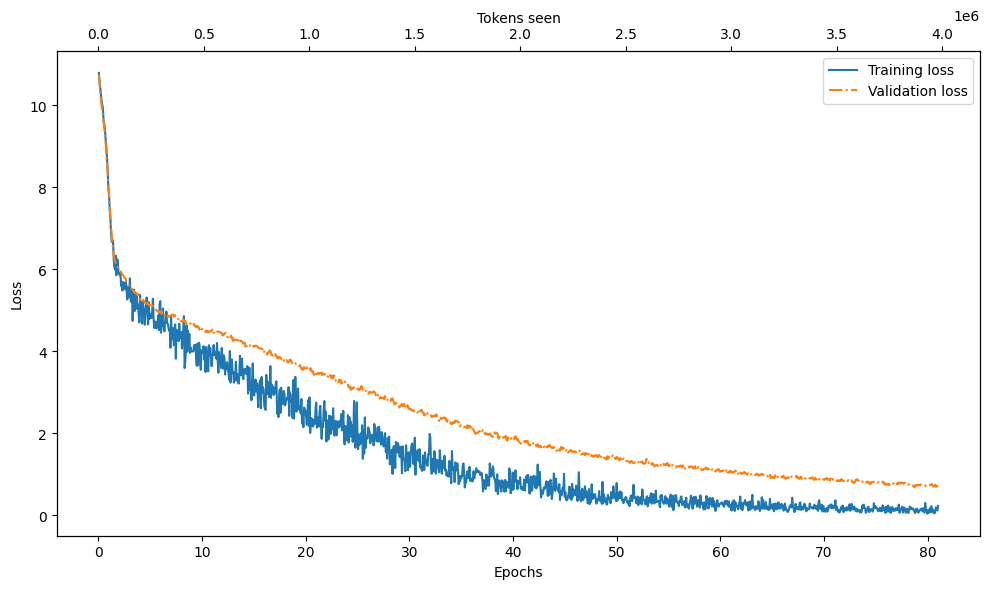

In [80]:
import matplotlib.pyplot as plt

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.show()

# Assuming train_losses, val_losses, epochs_seen, and tokens_seen are returned from the training function
# Plot the losses
plot_losses(training_results["epochs_seen"], training_results["tokens_seen"], training_results["train_losses"], training_results["val_losses"])

### Finetune On ColdPlay

In [82]:
# Create training and validation dataloaders for finetuning on Coldplay lyrics
finetune_train_dataloader = create_encoded_dataloader(
    joined_train_lyrics,
    tokenizer=tokenizer,
    batch_size=8,  # Slightly larger batch size for stability
    max_length=context_length,
    stride=context_length // 2,  # More overlap for better learning
    shuffle=True,
    drop_last=True
)

finetune_test_dataloader = create_encoded_dataloader(
    joined_test_lyrics,
    tokenizer=tokenizer,
    batch_size=8,
    max_length=context_length,
    stride=context_length // 2,
    shuffle=False,
    drop_last=True
)

# Define finetuning settings (optimized for finetuning)
settings = {
    "learning_rate": 3e-4,       # Faster convergence
    "weight_decay": 0.01,
    "num_epochs": 30,            # Much fewer epochs
    "batch_size": 2,              # Small batch for more updates
    "warmup_steps": 50,           # Minimal warmup
    "max_lr": 5e-4,               # Modest peak LR
    "min_lr": 1e-5,               # Higher floor to avoid very slow training
    "eval_freq": 1,               # Evaluate every epoch
    "eval_iter": -1,              # All validation data
    "gradient_clip": 0.6,
    "patience": 5,                # Stop if no improvement
    "min_improvement": 1e-4
}

def finetune_model_advanced(model, train_loader, val_loader, device, settings, tokenizer, context_length, start_context="Yellow lights"):
    """
    Advanced finetuning function with learning rate scheduling and warmup
    Specifically designed for finetuning pretrained models
    """
    # Initialize optimizer with lower learning rate for finetuning
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=settings["learning_rate"],
        weight_decay=settings["weight_decay"],
        betas=(0.9, 0.95)  # Better betas for transformer training
    )

    # Calculate total training steps
    total_steps = len(train_loader) * settings["num_epochs"]

    # Initialize scheduler with warmup (shorter for finetuning)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=settings["warmup_steps"],
        num_training_steps=total_steps
    )

    # Training tracking
    train_losses, val_losses = [], []
    epochs_seen, tokens_seen = [], []
    learning_rates = []
    total_tokens = 0
    global_step = 0

    # Early stopping
    best_val_loss = float('inf')
    patience_counter = 0

    print(f"Starting finetuning for {settings['num_epochs']} epochs")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Total training steps: {total_steps}")
    print(f"Warmup steps: {settings['warmup_steps']}")

    model.train()

    for epoch in range(settings["num_epochs"]):
        epoch_loss = 0.0
        num_batches = 0

        for i, (input_batch, target_batch) in enumerate(train_loader):
            global_step += 1
            total_tokens += input_batch.numel()

            # Forward pass
            loss = calc_loss_batch(input_batch, target_batch, model, device)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping (lower for finetuning)
            torch.nn.utils.clip_grad_norm_(model.parameters(), settings["gradient_clip"])

            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()
            num_batches += 1

            # Log current learning rate
            current_lr = scheduler.get_last_lr()[0]
            learning_rates.append(current_lr)

            # Evaluation and logging
            if global_step % settings["eval_freq"] == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, settings["eval_iter"]
                )

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                epochs_seen.append(epoch + (i + 1) / len(train_loader))
                tokens_seen.append(total_tokens)

                print(f"Epoch {epoch+1}/{settings['num_epochs']}, Step {global_step}: "
                      f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
                      f"LR={current_lr:.2e}, Tokens={total_tokens:,}")

                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    # Save best finetuned model
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'best_val_loss': best_val_loss,
                        'global_step': global_step,
                        'finetune_settings': settings
                    }, 'best_coldplay_finetuned_model.pth')
                    print(f"New best finetuned model saved! Val Loss: {val_loss:.4f}")
                else:
                    patience_counter += 1
                    if patience_counter >= settings["patience"]:
                        print(f"Early stopping triggered at epoch {epoch+1}, step {global_step}")
                        print(f"Best validation loss: {best_val_loss:.4f}")
                        return {
                            'train_losses': train_losses,
                            'val_losses': val_losses,
                            'epochs_seen': epochs_seen,
                            'tokens_seen': tokens_seen,
                            'learning_rates': learning_rates,
                            'best_val_loss': best_val_loss
                        }

        # End of epoch logging
        avg_epoch_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1} completed. Average loss: {avg_epoch_loss:.4f}")

        # Generate sample text at end of epoch (every 3 epochs for finetuning)
        if (epoch + 1) % 3 == 0:
            print(f"Sample generation after epoch {epoch+1}:")
            generate_and_print_sample(
                model, tokenizer, device, start_context, context_length, num_chars=80
            )
            print("-" * 50)

    print(f"Finetuning completed! Best validation loss: {best_val_loss:.4f}")
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'epochs_seen': epochs_seen,
        'tokens_seen': tokens_seen,
        'learning_rates': learning_rates,
        'best_val_loss': best_val_loss
    }

print(f"Starting finetuning on Coldplay lyrics...")
print(f"Training batches: {len(finetune_train_dataloader)}")
print(f"Validation batches: {len(finetune_test_dataloader)}")

# Start finetuning with improved training function
finetune_results = finetune_model_advanced(
    model,
    finetune_train_dataloader,
    finetune_test_dataloader,
    device,
    finetune_settings,
    tokenizer,
    context_length,
    start_context="Yellow lights"
)

print("Finetuning completed!")

# Save the final finetuned model
torch.save({
    'model_state_dict': model.state_dict(),
    'finetune_settings': finetune_settings,
    'results': finetune_results
}, 'coldplay_finetuned_model_final.pth')
print("Final finetuned model saved as 'coldplay_finetuned_model_final.pth'")

# Test generation with different prompts
test_prompts = [
    "Yellow lights",
    "Look at the stars",
    "When you try your best",
    "In the darkness"
]

print("\n" + "="*50)
print("TESTING FINETUNED MODEL GENERATION")
print("="*50)

model.eval()
for prompt in test_prompts:
    print(f"\nPrompt: '{prompt}'")
    print("-" * 30)
    try:
        context_tensor = text_to_token_ids(prompt, tokenizer, device)
        with torch.no_grad():
            generated_tokens = generate(
                model,
                max_new_tokens=80,  # Shorter generation for cleaner output
                context=context_tensor,
                context_length=context_length,
                temperature=0.8,  # Slightly creative but not too random
                top_k=50  # Limit to top 50 tokens for better quality
            )
            generated_text = token_ids_to_text(generated_tokens, tokenizer)
            print(generated_text)
    except Exception as e:
        print(f"Error generating text for prompt '{prompt}': {e}")

model.train()

# Plot finetuning losses
def plot_finetuning_losses(results):
    """Plot training and validation losses for finetuning"""
    import matplotlib.pyplot as plt

    epochs_seen = results['epochs_seen']
    train_losses = results['train_losses']
    val_losses = results['val_losses']
    learning_rates = results['learning_rates']

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Plot losses
    ax1.plot(epochs_seen, train_losses, label='Training Loss', color='blue', alpha=0.7)
    ax1.plot(epochs_seen, val_losses, label='Validation Loss', color='red', alpha=0.7)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Finetuning Losses')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss difference
    loss_diff = [val - train for val, train in zip(val_losses, train_losses)]
    ax2.plot(epochs_seen, loss_diff, label='Val - Train Loss', color='green', alpha=0.7)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss Difference')
    ax2.set_title('Overfitting Monitor')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    # Plot learning rate schedule
    ax3.plot(learning_rates, color='orange', alpha=0.7)
    ax3.set_xlabel('Steps')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate Schedule')
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')

    # Plot tokens seen vs loss
    tokens_seen = results['tokens_seen']
    ax4.plot(tokens_seen, train_losses, label='Training Loss', color='blue', alpha=0.7)
    ax4.plot(tokens_seen, val_losses, label='Validation Loss', color='red', alpha=0.7)
    ax4.set_xlabel('Tokens Seen')
    ax4.set_ylabel('Loss')
    ax4.set_title('Loss vs Tokens Processed')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('finetuning_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot the finetuning results
if len(finetune_results['train_losses']) > 0:
    plot_finetuning_losses(finetune_results)

# Comprehensive finetuning summary
print("\n" + "="*50)
print("FINETUNING SUMMARY")
print("="*50)
print(f"Final training loss: {finetune_results['train_losses'][-1]:.4f}")
print(f"Final validation loss: {finetune_results['val_losses'][-1]:.4f}")
print(f"Best validation loss: {finetune_results['best_val_loss']:.4f}")
print(f"Total epochs trained: {len(finetune_results['epochs_seen'])}")
print(f"Total tokens processed: {finetune_results['tokens_seen'][-1] if finetune_results['tokens_seen'] else 0:,}")
print(f"Final learning rate: {finetune_results['learning_rates'][-1]:.2e}")

# Calculate improvement metrics
if len(finetune_results['train_losses']) > 1:
    initial_train_loss = finetune_results['train_losses'][0]
    final_train_loss = finetune_results['train_losses'][-1]
    train_improvement = ((initial_train_loss - final_train_loss) / initial_train_loss) * 100

    initial_val_loss = finetune_results['val_losses'][0]
    final_val_loss = finetune_results['val_losses'][-1]
    val_improvement = ((initial_val_loss - final_val_loss) / initial_val_loss) * 100

    print(f"Training loss improvement: {train_improvement:.2f}%")
    print(f"Validation loss improvement: {val_improvement:.2f}%")

Starting finetuning on Coldplay lyrics...
Training batches: 23
Validation batches: 2
Starting finetuning for 30 epochs
Training batches: 23
Validation batches: 2
Total training steps: 690
Warmup steps: 100
Epoch 1/30, Step 20: Train Loss=4.0421, Val Loss=6.3826, LR=2.00e-06, Tokens=40,960
New best finetuned model saved! Val Loss: 6.3826
Epoch 1 completed. Average loss: 3.8453
Epoch 2/30, Step 40: Train Loss=3.6807, Val Loss=6.3123, LR=4.00e-06, Tokens=81,920
New best finetuned model saved! Val Loss: 6.3123
Epoch 2 completed. Average loss: 3.7734
Epoch 3/30, Step 60: Train Loss=3.5420, Val Loss=6.1779, LR=6.00e-06, Tokens=122,880
New best finetuned model saved! Val Loss: 6.1779
Epoch 3 completed. Average loss: 3.6261
Sample generation after epoch 3:
Yellow lights feel my heart my The summer, I had done I feel my heartest heart beating We could thirst We couldnt change me We could change We couldnt change, no again We always been in a oh oh, change We And we So I was're start So I   So I

KeyboardInterrupt: 

In [73]:
# Generate text using the trained model and the generate_text function
start_context = "I want something"
num_chars_to_generate = 500 # You can adjust this number
generated_tokens = generate(
    model=model,
    max_new_tokens=num_chars_to_generate,
    context=text_to_token_ids(start_context, tokenizer, device),
    context_length=context_length,
    temperature=0.8, # Adjust temperature for creativity
    top_k=None # Or specify a top_k value
)

print("Generated Text:")
decoded_text = token_ids_to_text(generated_tokens, tokenizer)

print(decoded_text.replace("\n", " "))

Generated Text:
... Oh, I was so hard Oh-ooh-oh-ooh, dont said, I remember But it waiting, I come at the sky, always have short I said,  Oh, oh-oh-ooh-ooh-ooh-ooh I said It the suna full of blood Now the sky full of blood Can the sky full of blood  hypoh-ooh-ooh-ooh-ooh-ooh, I curiosity it for theDaddy, youre such a Grail of blood One I said, cause the start, cause in the ground Oh, cause in the Kenya the sky full of purple  sound of escape theoh-ooh-ooh-ooh-ooh I fall I think the lights, I saw the sky, there bad the same view I know the ground I think  Nobodycrow the chaos all the ground I know the sky puppet on my heart flow I cry, I know theOne alight, youre the best of the... The deepestable it gets what the good is all theAnother But my heart The fear How all the streets I can stay until the


In [26]:
import torch
import torch.nn as nn
import numpy as np

def debug_model_and_data(model, train_dataloader, tokenizer, device):
    """Comprehensive debugging of model and data"""
    print("="*60)
    print("DEBUGGING MODEL AND DATA")
    print("="*60)

    # 1. Check data
    print("\n1. DATA ANALYSIS:")
    for batch_idx, (input_batch, target_batch) in enumerate(train_dataloader):
        if batch_idx == 0:  # Check first batch
            print(f"Input shape: {input_batch.shape}")
            print(f"Target shape: {target_batch.shape}")
            print(f"Input sample: {input_batch[0][:20]}")  # First 20 tokens
            print(f"Target sample: {target_batch[0][:20]}")

            # Decode to check if data makes sense
            sample_text = tokenizer.decode(input_batch[0][:50].tolist())
            print(f"Decoded sample: '{sample_text}'")

            # Check for data issues
            print(f"Input min/max: {input_batch.min()}/{input_batch.max()}")
            print(f"Vocab size: {tokenizer.n_vocab}")
            if input_batch.max() >= tokenizer.n_vocab:
                print("❌ ERROR: Token IDs exceed vocab size!")
                return False
            break

    # 2. Check model architecture
    print("\n2. MODEL ARCHITECTURE:")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # 3. Check model forward pass
    print("\n3. FORWARD PASS CHECK:")
    model.eval()
    with torch.no_grad():
        sample_input = input_batch[:1].to(device)  # Single sample
        try:
            output = model(sample_input)
            print(f"Model output shape: {output.shape}")
            print(f"Output range: {output.min():.4f} to {output.max():.4f}")

            # Check for NaN/Inf
            if torch.isnan(output).any():
                print("❌ ERROR: Model output contains NaN!")
                return False
            if torch.isinf(output).any():
                print("❌ ERROR: Model output contains Inf!")
                return False
            print("✅ Forward pass successful")
        except Exception as e:
            print(f"❌ ERROR in forward pass: {e}")
            return False

    # 4. Check loss calculation
    print("\n4. LOSS CALCULATION:")
    model.train()
    sample_input, sample_target = input_batch[:1].to(device), target_batch[:1].to(device)

    # Manual loss calculation
    logits = model(sample_input)
    loss = nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), sample_target.view(-1))
    print(f"Sample loss: {loss.item():.4f}")

    # Check what random guessing would give
    random_loss = np.log(tokenizer.n_vocab)
    print(f"Random guessing loss: {random_loss:.4f}")

    if loss.item() > random_loss + 1:
        print("⚠️  WARNING: Loss much higher than random guessing!")
        print("This suggests the model isn't learning properly")

    # 5. Check gradients
    print("\n5. GRADIENT CHECK:")
    loss.backward()

    grad_norms = []
    zero_grads = 0
    total_grads = 0

    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            grad_norms.append(grad_norm)
            if grad_norm == 0:
                zero_grads += 1
            total_grads += 1

    if grad_norms:
        print(f"Average gradient norm: {np.mean(grad_norms):.6f}")
        print(f"Max gradient norm: {np.max(grad_norms):.6f}")
        print(f"Min gradient norm: {np.min(grad_norms):.6f}")
        print(f"Zero gradients: {zero_grads}/{total_grads}")

        if np.mean(grad_norms) < 1e-6:
            print("❌ ERROR: Gradients too small (vanishing gradient problem)")
            return False
        elif np.max(grad_norms) > 100:
            print("❌ ERROR: Gradients too large (exploding gradient problem)")
            return False

    print("✅ All checks passed!")
    return True

In [27]:
debug_success = debug_model_and_data(model, train_dataloader, tokenizer, device)


DEBUGGING MODEL AND DATA

1. DATA ANALYSIS:
Input shape: torch.Size([2, 64])
Target shape: torch.Size([2, 64])
Input sample: tensor([ 2612,  4369,    11,   523,   326,   612,   550,   587,   645, 15223,
          670,   286,  8166,   438, 14363,  1986,   373,  1598,   290, 36519])
Target sample: tensor([ 4369,    11,   523,   326,   612,   550,   587,   645, 15223,   670,
          286,  8166,   438, 14363,  1986,   373,  1598,   290, 36519,    13])
Decoded sample: ' heart disease, so that there had been no preliminary work of destruction--his face was clear and untouched. I had met him once or twice, years before, and thought him insignificant and dingy. Now I saw that he was superb.

'
Input min/max: 1/44852
Vocab size: 50257

2. MODEL ARCHITECTURE:
Total parameters: 74,652,753
Trainable parameters: 74,652,753

3. FORWARD PASS CHECK:
Model output shape: torch.Size([1, 64, 50257])
Output range: -1.9403 to 1.9291
✅ Forward pass successful

4. LOSS CALCULATION:
Sample loss: 10.7634
Rand

## Character Tokenizer

In [ ]:
int_to_char = {}
for i, char in enumerate(characters):
    int_to_char[i] = char

char_to_int = {}

for value, char  in int_to_char.items():
    char_to_int[char] = value

print(int_to_char,char_to_int,end="\t")

In [ ]:


encoded_train = [char_to_int[c] for c in joined_train_lyrics if c in char_to_int]

encoded_test = [char_to_int[c] for c in joined_test_lyrics if c in char_to_int]

print(len(encoded_train),len(encoded_test))

In [ ]:

# context_length=3
# encoded= [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

def create_dataset(encoded, context_length=128):
  inputs, targets = [], []
  for i in range(len(encoded) - context_length):
    inputs.append(encoded[i:i+context_length])
    targets.append(encoded[i+1:i+context_length+1])
  return torch.tensor(inputs), torch.tensor(targets)

train_inputs, train_targets = create_dataset(encoded_train)
test_inputs, test_targets = create_dataset(encoded_test)



In [ ]:
from torch.utils.data import TensorDataset, DataLoader


def train(model):
  vocab_size = len(char_to_int)
  context_length = 128
  embed_dim = 128
  attention_dim = 128
  num_heads = 4
  num_blocks = 6
  epochs = 40
  lr = 0.001
  patience = 3
  batch_size = 32


  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
  best_loss = float('inf')
  patience_counter = 0
  losses, accuracies = [],[]

  train_loader = DataLoader(TensorDataset(train_inputs, train_targets), batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(TensorDataset(test_inputs, test_targets), batch_size=batch_size)


  for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for X, y in train_loader:
      X, y = X.to(device), y.to(device)
      optimizer.zero_grad()
      pred = model(X)
      pred_flat = pred.view(-1, vocab_size)
      y_flat = y.view(-1)
      loss = loss_func(pred_flat, y_flat)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      predictions = pred_flat.argmax(dim=1)
      correct += (predictions == y_flat).sum().item()
      total += y_flat.size(0)
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    losses.append(avg_loss)
    accuracies.append(accuracy)
    # Evaluation
    model.eval()
    eval_loss = 0
    with torch.no_grad():
      for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        pred_flat = pred.view(-1, vocab_size)
        y_flat = y.view(-1)
        loss = loss_func(pred_flat, y_flat)
        eval_loss += loss.item()
    eval_loss /= len(test_loader)
    print(f"Epoch {epoch+1}: Train Loss={avg_loss:.4f}, Accuracy={accuracy:.4f}, Eval Loss={eval_loss:.4f}")
    if avg_loss < best_loss:
      best_loss = avg_loss
      patience_counter = 0
      best_model_state = model.state_dict()
    else:
      patience_counter += 1
      if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        model.load_state_dict(best_model_state)
        break
  return model, epoch+1, losses, accuracies


In [ ]:
vocab_size = 83
context_length = 128
embed_dim = 128
attention_dim = 128
num_heads = 4
num_blocks = 6

model = GPT(num_heads, vocab_size, embed_dim, attention_dim, num_blocks, context_length).to(device)
#model.load_state_dict(torch.load("/content/trained_model-128-85.pth", weights_only=False))

model,epochs,losses,accuracies = train(model)
# Save the trained model
model_path = "trained_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


from google.colab import files
files.download('trained_model.pth')

### Cross Entropy
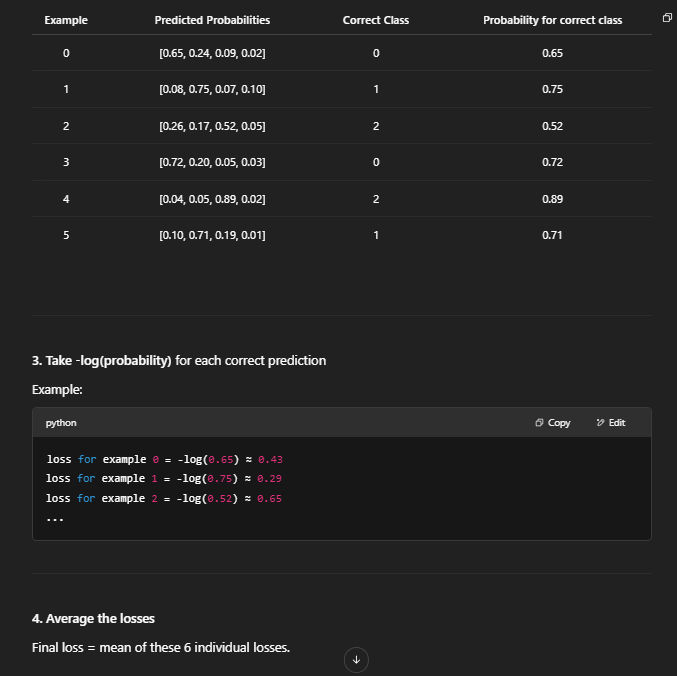

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), losses, marker='o')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), accuracies, marker='o', color='green')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [ ]:
# Training parameters
num_epochs = 10
eval_freq = 50  # Evaluate every 50 batches
eval_iter = 5   # Evaluate on 5 batches for training and validation loss calculation
learning_rate = 0.001
start_context = "The" # Starting text for generation

optimizer = AdamW(model.parameters(), lr=learning_rate)

# Start training
train_losses, val_losses = train_model(
    model, train_dataloader, test_dataloader, optimizer, device,
    num_epochs, eval_freq, eval_iter, start_context, tokenizer, context_length
)